In [ ]:
#Import necessary libraries

#Data Handling
import numpy as np
import pandas as pd

#Data Cleaning
import re
import missingno as msno

#Text Processing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from textblob import TextBlob

#Download necessary NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
#Load the datasets and Create an ExcelFile object
from google.colab import drive
drive.mount('/content/drive')
Data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ScouseHumour.csv')

Mounted at /content/drive


In [ ]:
#Initial check
print(Data.head(5))
print('\n')
print(Data.dtypes)
print('\n')
print(Data.info())
print('\n')
print(Data.isnull().sum())
print('\n')
print(Data.duplicated().sum())

                   Timestamp  Team  \
0  2023/07/26 2:48:34 pm CET     8   
1  2023/07/26 2:59:04 pm CET     1   
2  2023/07/26 3:22:19 pm CET     1   
3  2023/07/26 3:29:31 pm CET     7   
4  2023/07/26 3:42:02 pm CET     9   

  Do you think there is something distinctive about scouse humour?  \
0                                                Yes                 
1                                                Yes                 
2                                                Yes                 
3                                                Yes                 
4                                                Yes                 

  Do you have any thoughts on what makes it distinctive?  \
0                                            Sarcasm       
1  It disarms the offensive to seem inoffensive a...       
2                           Speed of whit and retort       
3                                               Wuff       
4  Its quick. Unless it Kev Coogan, whos always a.

In [ ]:
#Preprocessing: Rename the columns
Data.rename(columns={
    'Do you think there is something distinctive about scouse humour?' : 'DistinctiveHumour',
    'Do you have any thoughts on what makes it distinctive?' : 'ThoughtsOnDistinctive',
    'Do you think humour can help people deal with difficult experiences?' : 'DifficultExperiences',
    'If you answered yes or maybe, how do you think it helps?' : 'HowHumourHelps',
    'Would you mind saying what age group you belong to?' : 'AgeGroup',
    'How would you identify yourself from the following:' : 'Identity',
    'What is that first part of your postcode? E.g. L16' : 'FirstPartPostcode'
}, inplace=True)

#Check the columns headers
for col in Data.columns:
    print(col)

Timestamp
Team
DistinctiveHumour
ThoughtsOnDistinctive
DifficultExperiences
HowHumourHelps
AgeGroup
Identity
FirstPartPostcode


In [ ]:
#Preprocessing: Handle Missing Values
Data.loc[:, 'ThoughtsOnDistinctive'] = Data['ThoughtsOnDistinctive'].fillna('no response')
Data.loc[:, 'FirstPartPostcode'] = Data['FirstPartPostcode'].fillna('unknown')

print(Data.isnull().sum())
print('\n')
print(Data.info())

Timestamp                0
Team                     0
DistinctiveHumour        0
ThoughtsOnDistinctive    0
DifficultExperiences     0
HowHumourHelps           0
AgeGroup                 0
Identity                 0
FirstPartPostcode        0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 351 entries, 0 to 350
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Timestamp              351 non-null    object
 1   Team                   351 non-null    int64 
 2   DistinctiveHumour      351 non-null    object
 3   ThoughtsOnDistinctive  351 non-null    object
 4   DifficultExperiences   351 non-null    object
 5   HowHumourHelps         351 non-null    object
 6   AgeGroup               351 non-null    object
 7   Identity               351 non-null    object
 8   FirstPartPostcode      351 non-null    object
dtypes: int64(1), object(8)
memory usage: 24.8+ KB
None


In [ ]:
#Preprocessing: Update and Standardize data
Data['Timestamp'] = Data['Timestamp'].astype(str).str.replace(' CET', '', regex=False)
Data['Timestamp'] = pd.to_datetime(Data['Timestamp'])
Data['FirstPartPostcode'] = Data['FirstPartPostcode'].str.upper().str.strip()

print(Data.dtypes)

Timestamp                datetime64[ns]
Team                              int64
DistinctiveHumour                object
ThoughtsOnDistinctive            object
DifficultExperiences             object
HowHumourHelps                   object
AgeGroup                         object
Identity                         object
FirstPartPostcode                object
dtype: object


<ipython-input-6-3c7baa94843b>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  Data['Timestamp'] = pd.to_datetime(Data['Timestamp'])


In [ ]:
#Preprocessing: Analyze and Clean Unique Categories

Data['AgeGroup'] = Data['AgeGroup'].str.strip()
Data['Identity'] = Data['Identity'].str.strip().str.title()

print('AgeGroup:', Data["AgeGroup"].unique())
print('Identity:', Data["Identity"].unique())

AgeGroup: ['35-44' '85+' '45-54' '25-34' '19-24' 'Prefer not to say' '55-64' '65-74'
 'Under 18' '75-84']
Identity: ['Scouser' 'International' 'From Somewhere Else In The Uk' 'Northerner'
 'Northwesterner' 'Merseysider']


In [ ]:
#Preprocessing: Analyze and Clean Unique Categories

Data['Team'] = Data['Team'].astype('category')                                             #Update datatype

Data['FirstPartPostcode'] = Data['FirstPartPostcode'].str.replace(' ', '', regex=False)    #Remove spaces
InvalidEntries = ['LIBYA12', 'L1MMMMMMATE', "I'MNOTJOKING", 'IRELAND', 'CZECH', 'GLASGOW', '-', '296', '49456', 'UNKNOWN', '']
Data['FirstPartPostcode'] = Data['FirstPartPostcode'].apply(lambda x: 'INVALID' if x in InvalidEntries else x)
Data['FirstPartPostcode'] = Data['FirstPartPostcode'].apply(lambda x: 'INVALID' if re.search(r'\d{5,}', x) else x)  #Catch anything with more than 4 digits

print(Data['Team'].unique())
print('\n')
print(Data['FirstPartPostcode'].unique())

[8, 1, 7, 9, 3, ..., 6, 4, 10, 14, 2]
Length: 12
Categories (12, int64): [1, 2, 3, 4, ..., 9, 10, 11, 14]


['L189UZ' 'L18' 'L26' 'INVALID' 'L21' 'L25' 'L19' 'L23' 'L9' 'CH66' 'L17'
 'SK7' 'TD' 'AL2' 'L35' 'LN1' 'L5' 'E17' 'B65' 'L36' 'L12' 'CH63' 'KY15'
 'CH' 'L8' 'CH64' 'L32' 'L4' 'L39' 'L11' 'L34' 'TN12' 'L10' 'L22' 'L20'
 'L37' 'L13' 'I22' 'CH62' 'CT14' 'CV3' 'L7' 'L15' 'M1' 'PR8' 'PR6' 'PE14'
 'L30' 'CH47' 'L16' 'CH4' 'L14' 'M28' 'L1' 'L24' 'L2' 'L3' 'LL11' 'L33'
 'L253SF' 'L342RP' 'L185HA' 'CH44' 'WA8' 'E15' 'L31' 'FK5' 'WA10' 'WA2'
 'RM17' 'WA103SA' 'L28' 'WA9' 'CH3' 'CH40' 'CH41' 'DY11' 'OX44' 'CH45'
 'MK11' 'WN40DJ' 'OX5' 'CH42' 'BT13' 'WN6' 'L38' 'M23' 'CW12' 'BT66' 'LN8'
 'L126RQ' 'CH60' 'WA12' 'BA21' 'SW16' 'CT7' 'B42' 'BA22']


In [ ]:
#Preprocessing: Text cleaning

#!pip install nltk
import nltk
nltk.download('punkt_tab')

#Initialize
TextColumns = ['DistinctiveHumour', 'ThoughtsOnDistinctive', 'DifficultExperiences', 'HowHumourHelps']
Lemmatizer = WordNetLemmatizer()
StopWords = set(stopwords.words('english'))

#Create a function
def CleanText(text):
  text = text.lower()
  text = re.sub(r'[^a-z\s]', '', text)
  text = re.sub(r'([a-z])([A-Z])', r'\1 \2', text)
  text = re.sub(r'([a-z])([0-9])', r'\1 \2', text)
  text = re.sub(r'([0-9])([a-z])', r'\1 \2', text)
  text = re.sub(r'\s+', ' ', text)
  text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
  return text

#Apply the cleaning function
for column in TextColumns:
    Data[column] = Data[column].apply(CleanText)                                                              #Text cleaning

#Apply tokenization, lemmatization, stopword removal, and text reconstruction
for column in TextColumns:
    Data[column] = Data[column].apply(lambda x: word_tokenize(x) if isinstance(x, str) else x)
    Data[column] = Data[column].apply(lambda tokens: [Lemmatizer.lemmatize(word) for word in tokens] if isinstance(tokens, list) else tokens)
    Data[column] = Data[column].apply(lambda tokens: [word for word in tokens if word not in StopWords] if isinstance(tokens, list) else tokens)
    Data[column] = Data[column].apply(lambda tokens: ' '.join(tokens) if isinstance(tokens, list) else tokens)

print(Data[['DistinctiveHumour', 'ThoughtsOnDistinctive', 'DifficultExperiences', 'HowHumourHelps']].head(10))
print('\n')
print(Data[['DistinctiveHumour', 'ThoughtsOnDistinctive', 'DifficultExperiences', 'HowHumourHelps']].isnull().sum())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


  DistinctiveHumour                              ThoughtsOnDistinctive  \
0               yes                                            sarcasm   
1               yes        disarms offensive seem inoffensive humorous   
2               yes                                  speed whit retort   
3               yes                                               wuff   
4               yes  quick unless kev coogan always second behind pace   
5               yes                           sharp quickkkkkkk witted   
6               yes  quick witted use humour way coping community c...   
7               yes                         underdog underclass spirit   
8               yes                                   self deprecating   
9               yes       quick witted direct cutting self deprecating   

  DifficultExperiences                                     HowHumourHelps  
0                maybe                                    release tension  
1                  yes  take anxi

In [ ]:
#Topic modeling (Latent Dirichlet Allocation (LDA))

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

#Initialize TF-IDF
Vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)

#Fit and transform the text data
TextData = Data[TextColumns].apply(lambda row: ' '.join(row), axis=1)
TFIDF = Vectorizer.fit_transform(TextData)
X = Vectorizer.fit_transform(TextData)

#Apply LDA
Ntopics = 5
LDA = LatentDirichletAllocation(n_components=Ntopics, random_state=42)
LDA.fit(X)

#Display the topics
def TopWords(Model, FeatureNames, Ntop_words):
  for topic_idx, topic in enumerate(Model.components_):
    print('\n')
    print(f"Topic {topic_idx + 1}:")
    print(" ".join([FeatureNames[i] for i in topic.argsort()[:-Ntop_words - 1:-1]]))

#Get feature names
FeatureNames = Vectorizer.get_feature_names_out()

#Display the top words (per topic)
TopWords(LDA, FeatureNames, 10)



Topic 1:
yes maybe feel better people help cheer make accent good


Topic 2:
yes laughter medicine help laugh thing time mood light best


Topic 3:
yes make people funny release humour earth happy laugh maybe


Topic 4:
yes light situation dry making quite positive make help scouser


Topic 5:
yes mood quick witted people laugh lightens lift self maybe


In [ ]:
#Automatically label
from gensim.corpora import Dictionary
from gensim.models import LdaModel

Vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
TextData = Data[TextColumns].apply(lambda row: ' '.join(row), axis=1)
TFIDF = Vectorizer.fit_transform(TextData)
X = Vectorizer.fit_transform(TextData)

#Get vocabulary from vectorizer
vocabulary = Vectorizer.vocabulary_

#Tokenize the text data
TokenizedData = [doc.split() for doc in TextData]

#Create a Gensim dictionary from the tokenized data
dictionary = Dictionary(TokenizedData)

#Create a bag-of-words corpus using the dictionary
corpus = [dictionary.doc2bow(doc) for doc in TokenizedData]

#Apply LDA using gensim's LdaModel
Ntopics = 5
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=Ntopics, random_state=42) # Use gensim's LdaModel

#Get the topic distribution for each row
TopicProbabilities = [lda_model.get_document_topics(bow) for bow in corpus] # Now this line should work

#Assign the topic with the highest probability
Data['AutoLabel'] = [max(probs, key=lambda x: x[1])[0] for probs in TopicProbabilities]

#Check
#print(Data[['DistinctiveHumour', 'ThoughtsOnDistinctive', 'DifficultExperiences', 'HowHumourHelps', 'AutoLabel']].head(10))
print(Data['AutoLabel'].value_counts())

AutoLabel
0    145
3    127
1     44
2     18
4     17
Name: count, dtype: int64


In [ ]:
#Analyse Coherence Score (to find the best topic numbers)

from gensim.models import CoherenceModel

def compute_coherence_score(corpus, dictionary, num_topics):
    #Train the LDA model
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=42, passes=10)

    #Calculate the coherence score using the 'c_v' coherence measure
    coherence_model_lda = CoherenceModel(model=lda_model, texts=TokenizedData, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()

    return coherence_score

#Compute coherence for different numbers of topics (5, 10, and 15)
topics_list = [5, 10, 15]
coherence_scores = {}

for n_topics in topics_list:
    coherence_score = compute_coherence_score(corpus, dictionary, n_topics)
    coherence_scores[n_topics] = coherence_score

#Print the coherence scores
for n_topics, score in coherence_scores.items():
    print(f"Coherence Score for {n_topics} topics: {score}")

Coherence Score for 5 topics: 0.3710434687271273
Coherence Score for 10 topics: 0.36095531673455694
Coherence Score for 15 topics: 0.3526141475862985


In [ ]:
#Display the top words for each topic (to know the topic theme)
for i, topic in lda_model.show_topics(num_words=10, formatted=False):
    print(f"Topic {i}:")
    print([word[0] for word in topic])
    print("\n")

Topic 0:
['yes', 'situation', 'help', 'make', 'humour', 'quick', 'laugh', 'maybe', 'people', 'mood']


Topic 1:
['yes', 'make', 'take', 'maybe', 'thing', 'help', 'people', 'accent', 'difficult', 'feel']


Topic 2:
['yes', 'maybe', 'feel', 'help', 'always', 'make', 'think', 'laugh', 'situation', 'quick']


Topic 3:
['yes', 'people', 'help', 'humour', 'make', 'feel', 'laugh', 'accent', 'maybe', 'situation']


Topic 4:
['yes', 'maybe', 'make', 'laughing', 'people', 'thing', 'think', 'humour', 'accent', 'laugh']




<ipython-input-14-ec70df322fdd>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=TopicCounts.index, y=TopicCounts.values, palette="viridis")


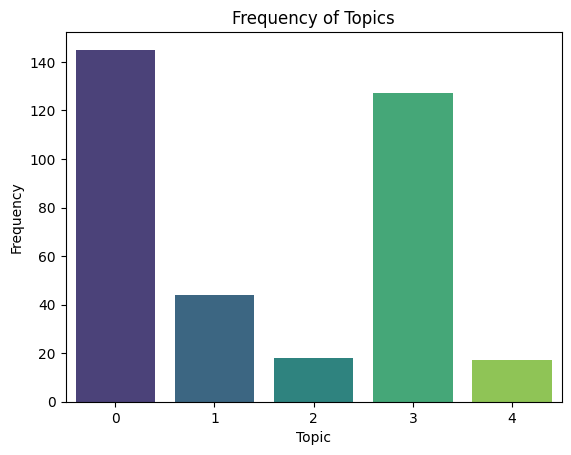

In [ ]:
#Frequency of topics

import matplotlib.pyplot as plt
import seaborn as sns

TopicCounts = Data['AutoLabel'].value_counts()
sns.barplot(x=TopicCounts.index, y=TopicCounts.values, palette="viridis")
plt.xlabel('Topic')
plt.ylabel('Frequency')
plt.title('Frequency of Topics')
plt.show()

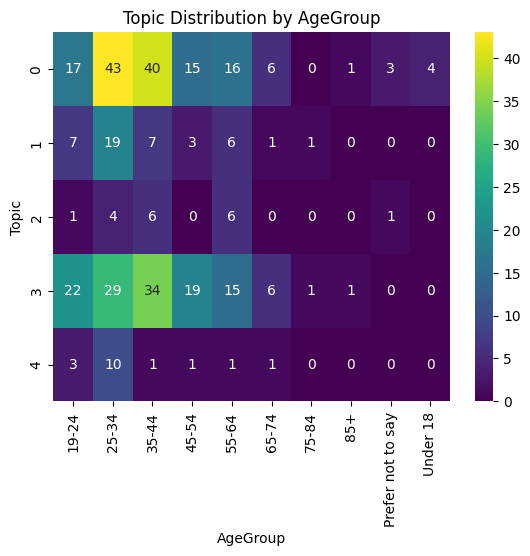

In [ ]:
#Analyze correlation (AgeGroup)

TopicAgeGroup = Data.groupby(['AutoLabel', 'AgeGroup']).size().unstack(fill_value=0)
sns.heatmap(TopicAgeGroup, annot=True, fmt='d', cmap='viridis')
plt.xlabel('AgeGroup')
plt.ylabel('Topic')
plt.title('Topic Distribution by AgeGroup')
plt.show()

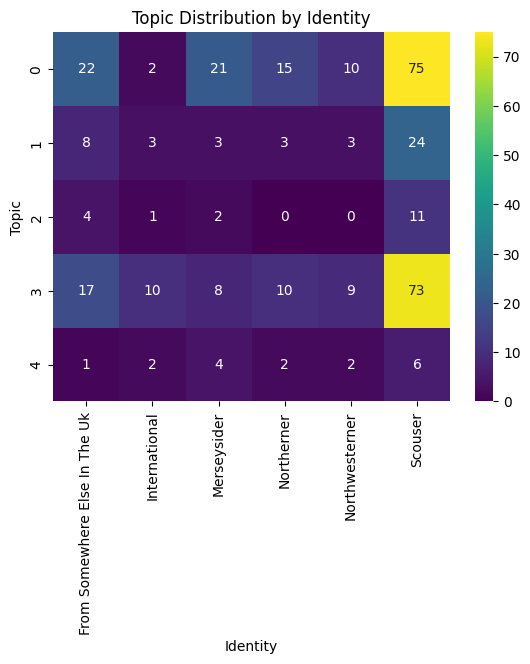

In [ ]:
#Analyze correlation (Identity)

TopicIdentity = Data.groupby(['AutoLabel', 'Identity']).size().unstack(fill_value=0)
sns.heatmap(TopicIdentity, annot=True, fmt='d', cmap='viridis')
plt.xlabel('Identity')
plt.ylabel('Topic')
plt.title('Topic Distribution by Identity')
plt.show()

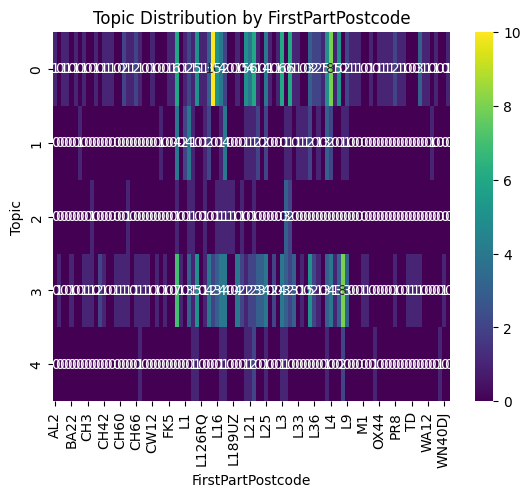

In [ ]:
#Analyze correlation (FirstPartPostcode)

TopicPostcode = Data.groupby(['AutoLabel', 'FirstPartPostcode']).size().unstack(fill_value=0)
sns.heatmap(TopicPostcode, annot=True, fmt='d', cmap='viridis')
plt.xlabel('FirstPartPostcode')
plt.ylabel('Topic')
plt.title('Topic Distribution by FirstPartPostcode')
plt.show()

Average Sentiment by Topic:
 AutoLabel
0    0.048266
1    0.011631
2    0.049842
3    0.045787
4    0.045404
Name: AverageSentiment, dtype: float64


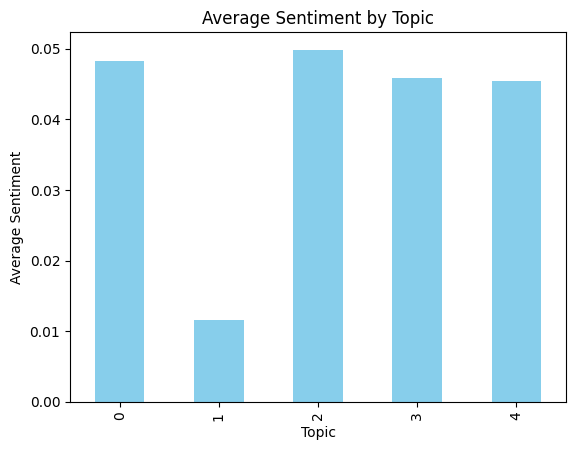

In [ ]:
#Sentiment Analysis (to score the emotional tone of responses)

from textblob import TextBlob

#Define the function
def Sen(text):
  Analysis = TextBlob(text)
  return Analysis.sentiment.polarity  #Value between -1 and 1

#Apply the function
for column in TextColumns:
    Data[f'{column}_Sentiment'] = Data[column].apply(lambda x: Sen(x) if isinstance(x, str) else 0)

#Get the average sentiment per topic
Data['AverageSentiment'] = Data[[f"{col}_Sentiment" for col in TextColumns]].mean(axis=1)
TopicSentiment = Data.groupby('AutoLabel')['AverageSentiment'].mean()
print("Average Sentiment by Topic:\n", TopicSentiment)

TopicSentiment.plot(kind='bar', color='skyblue')
plt.xlabel('Topic')
plt.ylabel('Average Sentiment')
plt.title('Average Sentiment by Topic')
plt.show()

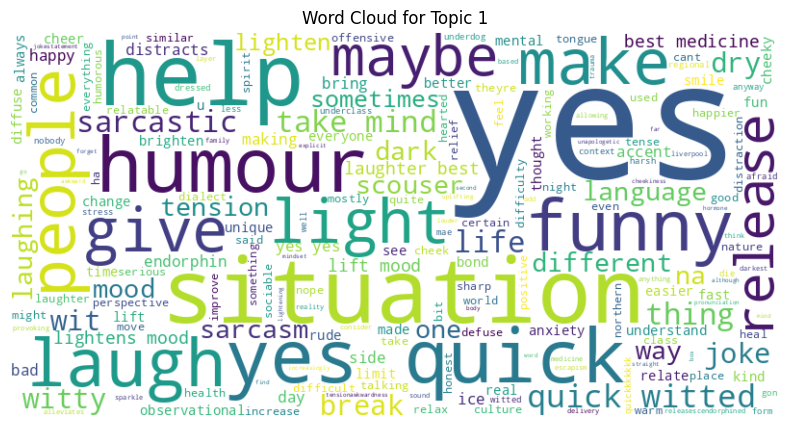

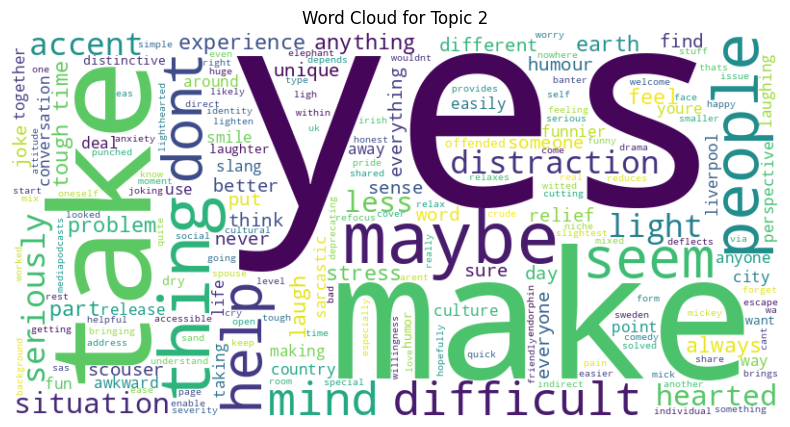

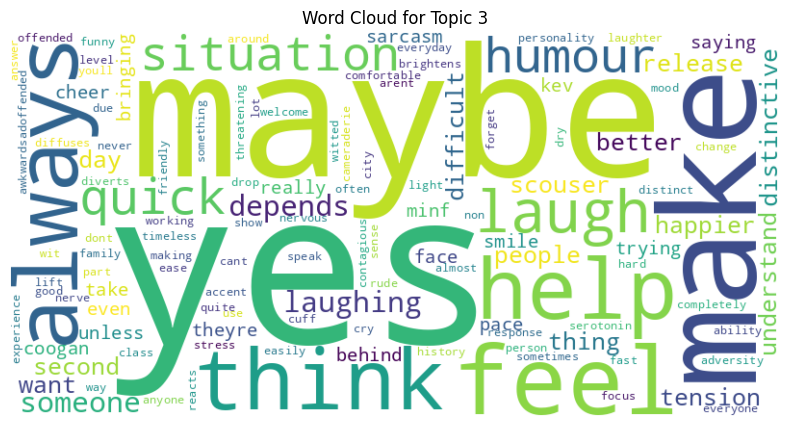

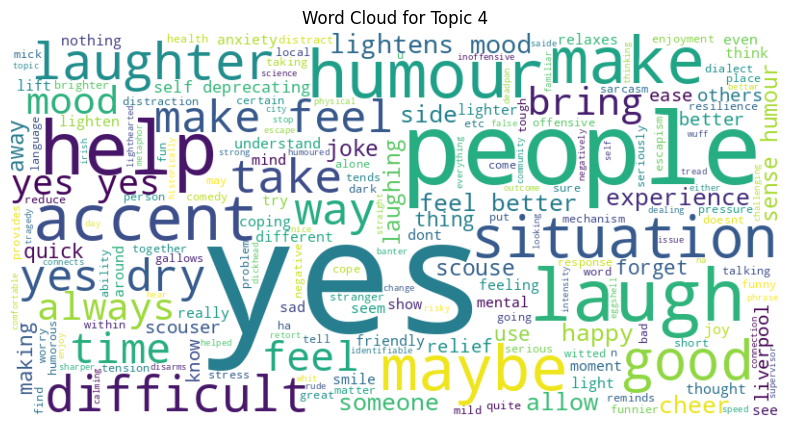

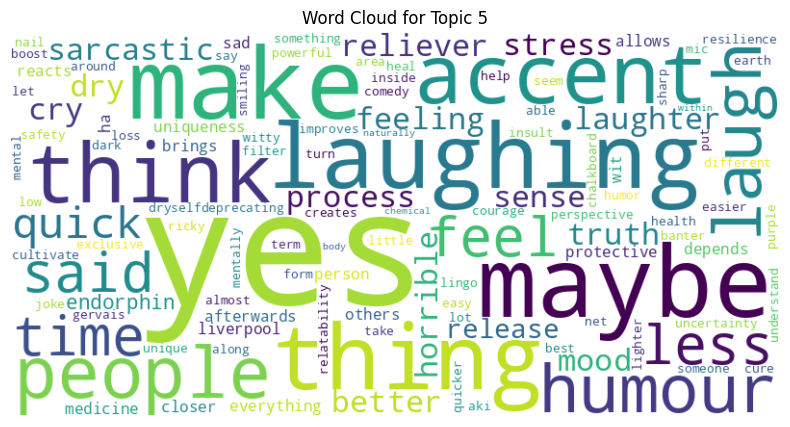

In [ ]:
#Find the most frequent words for among topics

from wordcloud import WordCloud

#Generate a word cloud
for topic in range(Ntopics):
  TopicWords = ' '.join([word for doc, topic_label in zip(TextData, Data['AutoLabel']) if topic_label == topic for word in doc.split()])
  wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(TopicWords)
  plt.figure(figsize=(10, 5))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title(f'Word Cloud for Topic {topic + 1}')
  plt.show()

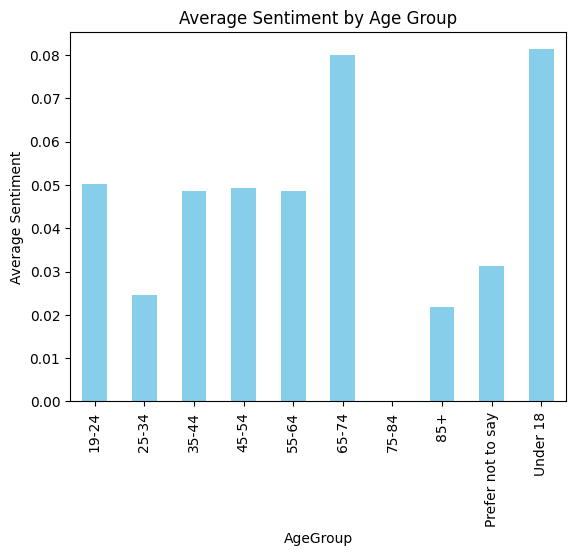



Cross-tabulation of Topics, AgeGroup, and Identity:
 AgeGroup   19-24  25-34  35-44  45-54  55-64  65-74  75-84  85+  \
AutoLabel                                                         
0           17.0   43.0   40.0   15.0   16.0    6.0    NaN  1.0   
1            7.0   19.0    7.0    3.0    6.0    1.0    1.0  NaN   
2            1.0    4.0    6.0    NaN    6.0    NaN    NaN  NaN   
3           22.0   29.0   34.0   19.0   15.0    6.0    1.0  1.0   
4            3.0   10.0    1.0    1.0    1.0    1.0    NaN  NaN   

AgeGroup   Prefer not to say  Under 18  
AutoLabel                               
0                        3.0       4.0  
1                        NaN       NaN  
2                        1.0       NaN  
3                        NaN       NaN  
4                        NaN       NaN  


In [ ]:
#Psychological Effects (Correlation of sentiment with AgeGroup)

SentimentAgegroup = Data.groupby('AgeGroup')['AverageSentiment'].mean()
SentimentAgegroup.plot(kind='bar', color='skyblue')
plt.title("Average Sentiment by Age Group")
plt.xlabel('AgeGroup')
plt.ylabel('Average Sentiment')
plt.show()
print('\n')

CrossTabulate = pd.crosstab(Data['AutoLabel'], Data['AgeGroup'], values=Data['Identity'], aggfunc='count')
print("Cross-tabulation of Topics, AgeGroup, and Identity:\n", CrossTabulate)  # Corrected variable name